# This notebook is to load in and merge external dataset to the main one

# 0 - Import necessary modules and begin spark

In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/09/15 11:42:23 WARN Utils: Your hostname, AshwinHPEnvy resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/09/15 11:42:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/15 11:42:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1 - Load in and clean external postcodes to SA2 dataset


In [ ]:
sa2_postcode_df = spark.read.csv('../data/SA2_to_Postcode/2023 Locality to 2021 SA2 Coding Index.csv', header = True, inferSchema = True)

# remove NaN postcodes
sa2_postcode_df = sa2_postcode_df.filter((sa2_postcode_df['POSTCODE'].isNotNull()) & (sa2_postcode_df['POSTCODE'] != 'NA'))
# cast POSTCODE col to int
sa2_postcode_df = sa2_postcode_df.withColumn('POSTCODE', sa2_postcode_df['POSTCODE'].cast('int'))

# run comments below to see table(s)
# print(f'Number of entries = {sa2_postcode_df.count()}')
# sa2_postcode_df = sa2_postcode_df.orderBy('POSTCODE', ascending = True)
# sa2_postcode_df.limit(5)

#### 1.9.2 - Load in the merged transactions dataset

In [ ]:
merge_df_FINAL = spark.read.parquet('../data/merged/merge_df_E.parquet')

# run comments below to see table(s)
#print(f'Number of entries = {merge_df_FINAL.count()}')
#merge_df_FINAL.limit(5)

#### 1.9.3 - Load in and clean external SA2 Population dataset 

In [ ]:
population_df = spark.read.csv('../data/external_data/SA2_ERP.csv', \
                               header = True, inferSchema = True)

# run comments below to see table(s)
#print(f'Number of entries = {population_df.count()}')
#population_df.show(truncate = False)

In [ ]:
# Rename columns (ERP = Estimated Resident Population)
if ('REGION: Region' in population_df.columns):
    population_df = population_df.withColumnRenamed('REGION: Region', 'SA2_code')
if ('OBS_VALUE' in population_df.columns):
    population_df = population_df.withColumnRenamed('OBS_VALUE', 'ERP')

# Only select data from 2023 (more recent)
population_df = population_df.filter(F.col('TIME_PERIOD: Time Period') == 2023)\
    .select('SA2_code', 'ERP')

# run comments below to see table(s)
#print(f'Number of entries = {population_df.count()}')
#population_df.show(truncate = False)

In [ ]:
# remove names from SA2_CODE
population_df = population_df.withColumn('SA2_code', F.split(F.col('SA2_code'), ':').getItem(0))

# run comments below to see table(s)
# population_df.limit(10)

In [ ]:
# create columns representing STATE, SA3 and SA4
population_df = population_df.withColumn('STATE', F.substring(F.col('SA2_code'), 1, 1))\
    .withColumn('SA4', F.substring(F.col('SA2_code'), 2, 2))\
    .withColumn('SA3', F.substring(F.col('SA2_code'), 4, 2))

# run comments below to see table(s)
#population_df.limit(10)

#### 1.9.4 - Load in and clean external income data

In [ ]:
income_df = spark.read.csv('../data/external_data/SA2_Income.csv', \
                           header = True, inferSchema = True)

# run comments below to see table(s)
#print(f'Number of entries = {income_df.count()}')
#income_df.limit(5)

In [ ]:
income_df = income_df.select("Statistical Areas Level 2 2021 code", 
"`Personal income: Total income earners (excl. Government pensions and allowances)(no.) (Data year: 2020)`",
"`Personal income: Total income (excl. Government pensions and allowances) ($m) (Data year: 2020)`", 
"`Personal income: Median total income (excl. Government pensions and allowances) ($) (Data year: 2020)`", 
"`Personal income: Mean total income (excl. Government pensions and allowances) ($) (Data year: 2020)`", 
"`Personal income: Total income (excl. Government pensions and allowances): Gini coefficient (Data year: 2020)`")

# Rename columns
# SA2 code
if (income_df.columns[0] in income_df.columns):
    income_df = income_df.withColumnRenamed(income_df.columns[0], 'SA2_code')
# Number of income earners
if (income_df.columns[1] in income_df.columns):
    income_df = income_df.withColumnRenamed(income_df.columns[1], 'num_earners') 
# Total income
if (income_df.columns[2] in income_df.columns):
    income_df = income_df.withColumnRenamed(income_df.columns[2], 'total_income_($M)')
# Median total income
if (income_df.columns[3] in income_df.columns):
    income_df = income_df.withColumnRenamed(income_df.columns[3], 'median_income')
# Mean total income
if (income_df.columns[4] in income_df.columns):
    income_df = income_df.withColumnRenamed(income_df.columns[4], 'mean_income')
# Gini coefficient
if (income_df.columns[5] in income_df.columns):
    income_df = income_df.withColumnRenamed(income_df.columns[5], 'gini_coef')

# run comments below to see table(s)
#print(f'Number of entries = {income_df.count()}')
#income_df.limit(5)

#### 1.9.5 - Merging Income with Population data

In [ ]:
# merge on SA2_code
pop_income_df = population_df.join(F.broadcast(income_df),
                                           population_df.SA2_code == income_df.SA2_code,
                                           how = 'left'
                                           ).drop(income_df.SA2_code)
# order table by ERP
pop_income_df = pop_income_df.orderBy('ERP', ascending = False)

# run comments below to see table(s)
#print(f'Number of entries = {pop_income_df.count()}')
#pop_income_df.limit(20)

#### 1.9.6 - Income Imputation

A lot of NULL values in fields relating to income. So, we need to impute missing values before we can do the final merges.

##### 1.9.6.1 - ERP == 0

In [11]:
# Count number of null and non-null entries for total_income
print(f'Number of NULL entries = {pop_income_df.filter(F.col("total_income_($M)")\
                                                       .isNull()).count()}')
print(f'Number of non-NULL entries = {pop_income_df.filter(F.col("total_income_($M)")\
                                                           .isNotNull()).count()}')

Number of NULL entries = 437
Number of non-NULL entries = 2017


In [12]:
# if ERP = 0, total_income = 0
pop_income_df = pop_income_df.withColumn(
    "total_income_($M)",
    F.when((F.col('ERP') == 0) & F.col("total_income_($M)").isNull(), 0).otherwise(F.col("total_income_($M)"))
)

# Count number of null and non-null entries
print(f'Number of NULL entries = {pop_income_df.filter(F.col("total_income_($M)")\
                                                       .isNull()).count()}')
print(f'Number of non-NULL entries = {pop_income_df.filter(F.col("total_income_($M)")\
                                                           .isNotNull()).count()}')
# run comments below to see table(s)
#pop_income_df.orderBy('ERP').limit(50)

Number of NULL entries = 401
Number of non-NULL entries = 2053


SA2_code,ERP,STATE,SA4,SA3,num_earners,total_income_($M),median_income,mean_income,gini_coef
801041117,0,8,01,04,NULL,0.0,NULL,NULL,NULL
312031360,0,3,12,03,NULL,0.0,NULL,NULL,NULL
801071085,0,8,01,07,NULL,0.0,NULL,NULL,NULL
310021279,0,3,10,02,NULL,0.0,NULL,NULL,NULL
801051128,0,8,01,05,NULL,0.0,NULL,NULL,NULL
404021098,0,4,04,02,NULL,0.0,NULL,NULL,NULL
205021083,0,2,05,02,NULL,0.0,NULL,NULL,NULL
504031064,0,5,04,03,NULL,0.0,NULL,NULL,NULL
801051123,0,8,01,05,NULL,0.0,NULL,NULL,NULL
801041116,0,8,01,04,NULL,0.0,NULL,NULL,NULL


In [13]:
# if ERP = 0, num_earners = 0
pop_income_df = pop_income_df.withColumn(
    "num_earners",
    F.when((F.col('ERP') == 0) & F.col("num_earners").isNull(), 0)\
        .otherwise(F.col("num_earners"))
)

# Count number of null and non-null entries
print(f'Number of NULL entries = {pop_income_df.filter(F.col("num_earners")\
                                                       .isNull()).count()}')
print(f'Number of non-NULL entries = {pop_income_df.filter(F.col("num_earners")\
                                                           .isNotNull()).count()}')

# run comments below to see table(s)
#pop_income_df.orderBy('ERP').limit(50)

Number of NULL entries = 401
Number of non-NULL entries = 2053


SA2_code,ERP,STATE,SA4,SA3,num_earners,total_income_($M),median_income,mean_income,gini_coef
801041117,0,8,01,04,0,0.0,NULL,NULL,NULL
312031360,0,3,12,03,0,0.0,NULL,NULL,NULL
801071085,0,8,01,07,0,0.0,NULL,NULL,NULL
310021279,0,3,10,02,0,0.0,NULL,NULL,NULL
801051128,0,8,01,05,0,0.0,NULL,NULL,NULL
404021098,0,4,04,02,0,0.0,NULL,NULL,NULL
205021083,0,2,05,02,0,0.0,NULL,NULL,NULL
504031064,0,5,04,03,0,0.0,NULL,NULL,NULL
801051123,0,8,01,05,0,0.0,NULL,NULL,NULL
801041116,0,8,01,04,0,0.0,NULL,NULL,NULL


##### 1.9.6.2 - Create plots for non-zero ERPs

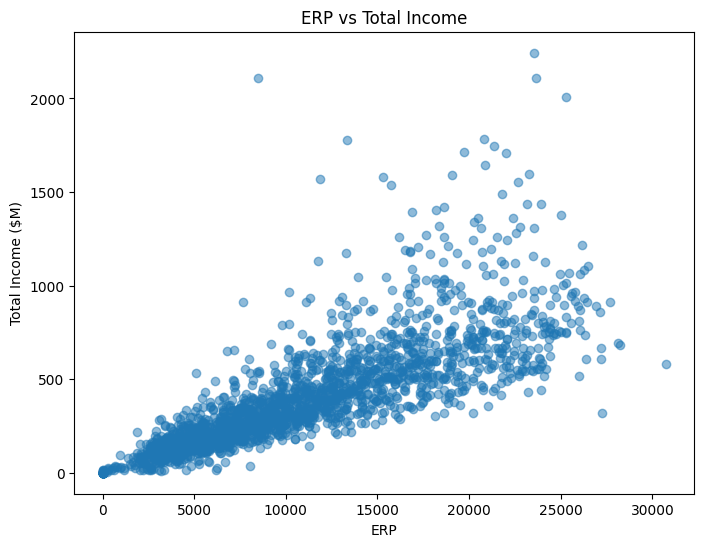

In [14]:
import matplotlib.pyplot as plt

# collect ERP and total_income colunms
erp_data = pop_income_df.select('ERP').rdd.flatMap(lambda x: x).collect()
total_income_data = pop_income_df.select('total_income_($M)').rdd.flatMap(lambda x: x).collect()

# plot
plt.figure(figsize = (8, 6))
plt.scatter(erp_data, total_income_data, alpha = 0.5)

# title and labels
plt.xlabel('ERP')
plt.ylabel('Total Income ($M)')
plt.title('ERP vs Total Income')

plt.show()

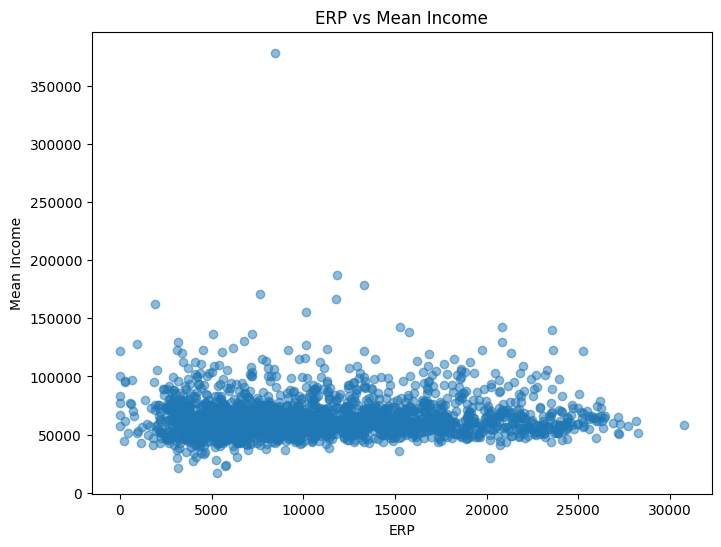

In [15]:
# collect mean_income column
mean_income_data = pop_income_df.select('mean_income').rdd.flatMap(lambda x: x).collect()

# plot
plt.figure(figsize = (8, 6))
plt.scatter(erp_data, mean_income_data, alpha = 0.5)

# title and labels
plt.xlabel('ERP')
plt.ylabel('Mean Income')
plt.title('ERP vs Mean Income')

plt.show()

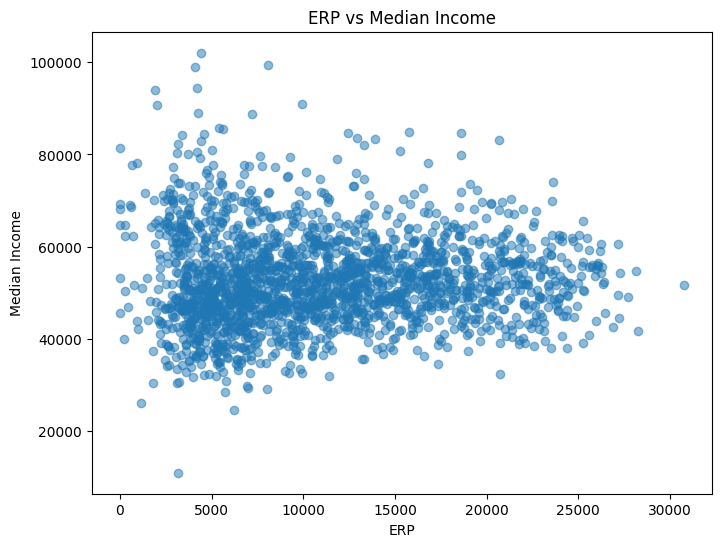

In [16]:
# collect median_income column
median_income_data = pop_income_df.select('median_income').rdd.flatMap(lambda x: x).collect()

# plot
plt.figure(figsize = (8, 6))
plt.scatter(erp_data, median_income_data, alpha = 0.5)

# title and labels
plt.xlabel('ERP')
plt.ylabel('Median Income')
plt.title('ERP vs Median Income')

plt.show()

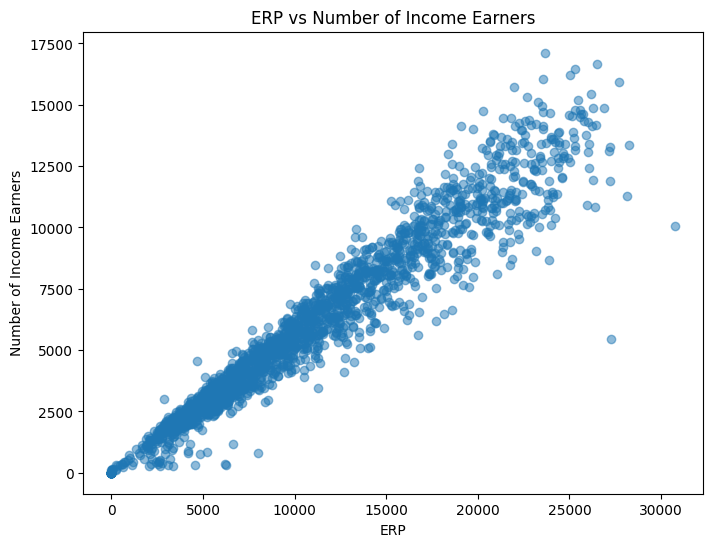

In [17]:
# collect num_earners column
num_earners_data = pop_income_df.select('num_earners').rdd.flatMap(lambda x: x).collect()

# plot
plt.figure(figsize = (8, 6))
plt.scatter(erp_data, num_earners_data, alpha = 0.5)

# title and labels
plt.xlabel('ERP')
plt.ylabel('Number of Income Earners')
plt.title('ERP vs Number of Income Earners')

plt.show()

##### 1.9.6.3 - Impute Total Income

In [ ]:
import pandas as pd

# convert pop_income_df to pandas for imputer
pop_income_pdf = pop_income_df.toPandas()

# one-hot encode STATE, SA4 and SA3
pop_income_pdf = pd.get_dummies(pop_income_pdf, columns = ['STATE', 'SA4', 'SA3'])

# run comments below to see table(s)
#pop_income_pdf.head()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# separate missing and non-missing values
df_non_missing = pop_income_pdf[pop_income_pdf['total_income_($M)'].notna()]
df_missing = pop_income_pdf[pop_income_pdf['total_income_($M)'].isna()]

# define X and y matrices
X = df_non_missing.drop(columns = ['total_income_($M)', 'SA2_code', 'num_earners', 'median_income', 'mean_income', 'gini_coef'])
y = df_non_missing['total_income_($M)']

# Random Forest Regression
model = RandomForestRegressor(n_estimators = 200, random_state = 13)
model.fit(X, y)

# predict missing rows
X_missing = df_missing.drop(columns = ['total_income_($M)', 'SA2_code', 'num_earners', 'median_income', 'mean_income', 'gini_coef'])
predicted_values = model.predict(X_missing)

# put predicted missing values back into pop_income
pop_income_pdf.loc[df_missing.index, 'total_income_($M)'] = predicted_values
pop_income_pdf = pop_income_pdf.sort_values(by = 'total_income_($M)')

# run comments below to see table(s)
#pop_income_pdf.head(20)

In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error

# measure RMSE for model fit
y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE on non-NULL values: {rmse:.4f}')

RMSE on non-NULL values: 50.3265


##### 1.9.6.3 - Impute num_earners

In [ ]:
# separate missing and non-missing values
df_non_missing = pop_income_pdf[pop_income_pdf['num_earners'].notna()]
df_missing = pop_income_pdf[pop_income_pdf['num_earners'].isna()]

# get X and y matrices
X = df_non_missing.drop(columns = ['total_income_($M)', 'SA2_code', 'num_earners', 'median_income', 'mean_income', 'gini_coef'])
y = df_non_missing['num_earners']

# Random Forest Regression
model = RandomForestRegressor(n_estimators = 200, random_state = 13)
model.fit(X, y)

# predict missing rows
X_missing = df_missing.drop(columns = ['total_income_($M)', 'SA2_code', 'num_earners', 'median_income', 'mean_income', 'gini_coef'])
predicted_values = model.predict(X_missing)

# round predictions to nearest integer (as num_earners is a count)
predicted_values_rounded = np.round(predicted_values).astype(int)

# num_earners ≤ ERP
erp_values = df_missing['ERP'].values
adjusted_values = np.minimum(predicted_values_rounded, erp_values)

# put predicted missing values back into pop_income
pop_income_pdf.loc[df_missing.index, 'num_earners'] = adjusted_values
pop_income_pdf = pop_income_pdf.sort_values(by = 'num_earners')

# run comments below to see table(s)
#pop_income_pdf.head(20)

In [22]:
# measure RMSE for model fit
y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f'RMSE on non-NULL values: {rmse:.4f}')

RMSE on non-NULL values: 326.0099


##### 1.9.6.4 - Saving data

In [ ]:
# convert pop_income_pdf back to spark
pop_income_df = spark.createDataFrame(pop_income_pdf[['SA2_code', 'ERP', \
                                        'num_earners', 'total_income_($M)', 'mean_income']])
pop_income_df = pop_income_df.orderBy('ERP', ascending = False)

# run comments below to see table(s)
#pop_income_df.limit(20)

In [ ]:
# create additional columns for STATE, SA4, SA3
pop_income_df = pop_income_df.withColumn('STATE', F.substring(F.col('SA2_code'), 1, 1))\
    .withColumn('SA4', F.substring(F.col('SA2_code'), 2, 2))\
    .withColumn('SA3', F.substring(F.col('SA2_code'), 4, 2))

# run comments below to see table(s)
#pop_income_df.limit(20)

In [ ]:
# fill NULL mean_income
mean_income_pred = F.col('total_income_($M)') * 1000000 / F.col('num_earners')

pop_income_df = pop_income_df.withColumn(
    'mean_income', 
    F.when((F.col('num_earners') == 0) & F.isnan(F.col('mean_income')), 0)
    .when(F.isnan(F.col('mean_income')), mean_income_pred)
    .otherwise(F.col('mean_income'))
)

# run comments below to see table(s)
#pop_income_df.limit(20)

In [26]:
from pyspark.sql.types import IntegerType

# convert num_earners to int
pop_income_df = pop_income_df.withColumn('num_earners', F.col('num_earners').cast(IntegerType()))
pop_income_df.printSchema()

root
 |-- SA2_code: string (nullable = true)
 |-- ERP: long (nullable = true)
 |-- num_earners: integer (nullable = true)
 |-- total_income_($M): double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- STATE: string (nullable = true)
 |-- SA4: string (nullable = true)
 |-- SA3: string (nullable = true)



In [ ]:
# reorder columns
column_order = ['SA2_code', 'STATE', 'SA4', 'SA3', 'ERP', 'num_earners',\
                 'total_income_($M)', 'mean_income']
pop_income_df = pop_income_df.select(*column_order)

# run comments below to see table(s)
#pop_income_df.limit(20)

In [28]:
# save the table
pop_income_df.write.mode('overwrite').parquet('../data/merged/pop_income.parquet')

#### 1.9.7 - Merging with transactions

##### 1.9.7.1 - Read in data

In [ ]:
pop_income_df = spark.read.parquet('../data/merged/pop_income.parquet')

# run comments below to see table(s)
#pop_income_df.limit(20)

In [ ]:
from pyspark.sql import functions as F

sa2_postcode_df = spark.read.csv('../data/SA2_to_Postcode/2023 Locality to 2021 SA2 Coding Index.csv', header = True, inferSchema = True)

# remove NaN postcodes
sa2_postcode_df = sa2_postcode_df.filter((sa2_postcode_df['POSTCODE'].isNotNull()) & (sa2_postcode_df['POSTCODE'] != 'NA'))
# cast POSTCODE col to int
sa2_postcode_df = sa2_postcode_df.withColumn('POSTCODE', sa2_postcode_df['POSTCODE'].cast('int'))

# order table by POSTCODE
sa2_postcode_df = sa2_postcode_df.orderBy('POSTCODE', ascending = True)

# run comments below to see table(s)
#print(f'Number of entries = {sa2_postcode_df.count()}')
#sa2_postcode_df.limit(5)

##### 1.9.7.2 - Merge pop_income with postcodes

In [ ]:
# group by POSTCODE and aggregate SA2_MAINCODE_2021
grouped_sa2_df = sa2_postcode_df.groupBy('POSTCODE').agg(
    # name only here for general idea of where the location is
    F.first('LOCALITY_NAME').alias('LOCALITY_NAME'),
    # find most common STATE in POSTCODE
    F.expr('element_at(array_sort(array_distinct(collect_list(STATE))), 1)').alias('STATE'),
    # collect unique SA2
    F.collect_set('SA2_MAINCODE_2021').cast('array<int>').alias('SA2_CODES')
)

# run comments below to see table(s)
#print(f'Number of entries = {grouped_sa2_df.count()}')
#grouped_sa2_df.show(truncate = False)

In [ ]:
# Expand out SA2_CODES
expanded_sa2_df = grouped_sa2_df.select('POSTCODE','LOCALITY_NAME','STATE',
    F.explode('SA2_CODES').alias('SA2_CODE'))

# run comments below to see table(s)
#print(f'Number of entries = {expanded_sa2_df.count()}')
#expanded_sa2_df.show(truncate = False)

In [ ]:
# merge on SA2_CODE
POA_pi_df = expanded_sa2_df.join(F.broadcast(pop_income_df),
    expanded_sa2_df.SA2_CODE == pop_income_df.SA2_code,
    how = 'left'
    ).drop(pop_income_df.SA2_code, pop_income_df.STATE, pop_income_df.SA4, pop_income_df.SA3)

# run comments below to see table(s)
#print(f'Number of entries = {POA_pi_df.count()}')
#POA_pi_df = POA_pi_df.orderBy('POSTCODE')
#POA_pi_df.limit(20)

In [ ]:
# groupby the table on POSTCODE
grouped_pi_df = POA_pi_df.groupBy('POSTCODE').agg(
    # locality name
    F.first('LOCALITY_NAME').alias('LOCALITY_NAME'),
    # state
    F.first('STATE').alias('STATE'),
    # SA2 codes
    F.collect_list('SA2_CODE').cast('array<int>').alias('list_SA2_CODE'),
    # ERP
    F.collect_list('ERP').cast('array<int>').alias('list_ERP'),
    # number of income earners
    F.collect_list('num_earners').cast('array<int>').alias('list_num_earners'),
    # total_income
    F.collect_list('total_income_($M)').cast('array<double>').alias('list_total_income_($M)'),
    # mean_income
    F.collect_list('mean_income').cast('array<double>').alias('list_mean_income')
)

# run comments below to see table(s)
#print(f'Number of entries = {grouped_pi_df.count()}')
#grouped_pi_df.show(truncate = False)

In [ ]:
# sum ERP
grouped_pi_df = grouped_pi_df.withColumn('postcode_ERP', 
    F.expr('aggregate(list_ERP, 0, (x, y) -> x + y)'))

# run comments below to see table(s)
#grouped_pi_df.limit(20)

In [ ]:
# sum number of income earners
grouped_pi_df = grouped_pi_df.withColumn('postcode_num_earners', 
    F.expr('aggregate(list_num_earners, 0, (x, y) -> x + y)'))

# run comments below to see table(s)
#grouped_pi_df.limit(20)

In [ ]:
# sum total_income
grouped_pi_df = grouped_pi_df.withColumn("postcode_total_income_($M)", 
    F.expr("aggregate(`list_total_income_($M)`, 0D, (x, y) -> x + y)"))

# run comments below to see table(s)
#grouped_pi_df.limit(20)

In [ ]:
# create field to denote, only 1 SA2 in postcode
grouped_pi_df = grouped_pi_df.withColumn('single_SA2',
    F.size(F.col('list_SA2_CODE')) == 1)

# calculate postcode mean income
grouped_pi_df = grouped_pi_df.withColumn(
    'postcode_mean_income', 
    F.when(F.col('single_SA2'), 
           F.expr('element_at(list_mean_income, 1)'))
     .otherwise(
         F.when(F.col('postcode_num_earners') > 0, 
                F.col("postcode_total_income_($M)") * 1000000 / F.col("postcode_num_earners"))
         .otherwise(0)
     )
)

# drop temporary column
grouped_pi_df = grouped_pi_df.drop('single_SA2')

# run comments below to see table(s)
#grouped_pi_df.limit(20)


In [39]:
# save merged population, income, and postcode table
grouped_pi_df.write.mode('overwrite').parquet('../data/merged/postcode_grouped_PI.parquet')

##### 1.9.7.3 - Merging with Transactions

In [ ]:
# Load in the merged population, income, and postcode table
grouped_pi_df = spark.read.parquet('../data/merged/postcode_grouped_PI.parquet')

# run comments below to see table(s)
#print(f'Number of entries = {grouped_pi_df.count()}')
#grouped_pi_df.limit(20)

In [ ]:
# Load in merged transactions table
merge_df_FINAL = spark.read.parquet('../data/merged/merge_df_E.parquet')

# run comments below to see table(s)
#print(f'Number of entries = {merge_df_FINAL.count()}')
#merge_df_FINAL.limit(5)

In [ ]:
# merge the tables on POSTCODE
transactions_FINAL_df = merge_df_FINAL.join(F.broadcast(grouped_pi_df),
                                 merge_df_FINAL.postcode == grouped_pi_df.POSTCODE,
                                 how = 'left'
                                 ).drop(grouped_pi_df.POSTCODE, grouped_pi_df.STATE)

# run comments below to see table(s)
#print(f'Number of entries = {transactions_FINAL_df.count()}')
#transactions_FINAL_df.limit(5)

In [43]:
# save merged transactions, postcode, population, and income table
transactions_FINAL_df.write.mode('overwrite').parquet('../data/merged/transactions_POA_PI.parquet')

In [44]:
# check the save
transactions_POA_PI_df = spark.read.parquet('../data/merged/transactions_POA_PI.parquet')
print(f'Number of entries = {transactions_POA_PI_df.count()}')
transactions_POA_PI_df.limit(5)

Number of entries = 14195717


user_id,merchant_abn,dollar_value,order_id,order_datetime,merchant_name,tags,consumer_id,name,address,state,postcode,gender,consumer_fraud_order_datetime,consumer_fraud_probability,merchant_fraud_order_datetime,merchant_fraud_probability,LOCALITY_NAME,list_SA2_CODE,list_ERP,list_num_earners,list_total_income_($M),list_mean_income,postcode_ERP,postcode_num_earners,postcode_total_income_($M),postcode_mean_income
14935,42211422632,267.27434032207714,4c115de8-0e36-413...,2021-12-22,NULL,NULL,1059280,Cameron Adams,0280 Carpenter Lodge,QLD,4563,Male,NULL,NULL,NULL,NULL,BLACK MOUNTAIN,"[319031514, 31608...","[21774, 25578]","[10606, 14487]","[510.4, 798.8]","[48127.0, 55139.0]",47352,25093,1309.1999999999998,52173.91304347825
1,20939962818,219.99544086086206,42fbb736-43eb-471...,2021-12-22,Semper Cursus Ins...,"((opticians, opti...",1195503,Yolanda Williams,413 Haney Gardens...,WA,6935,Female,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL
14936,38523562929,56.450082555271926,ff62019c-5864-42e...,2021-12-22,Sed Dictum Corp.,"((cable, satellit...",986886,Maria Riley,416 Phillip View ...,SA,5157,Female,NULL,NULL,NULL,NULL,ASHBOURNE,"[407011147, 40304...","[8376, 2824, 7111]","[4446, 1754, 4110]","[234.3, 115.0, 23...","[52688.0, 65560.0...",18311,10310,586.0,56838.0213385063
3,30415756696,520.1489211494473,224d7a02-2b87-485...,2021-12-22,Nec Mollis PC,[(music shops - m...,1194530,Jill Jones MD,40693 Henry Greens,NT,862,Female,NULL,NULL,NULL,NULL,ALROY DOWNS,"[702021055, 70205...","[2526, 4852]","[342, 768]","[15.9, 34.4]","[46619.0, 44778.0]",7378,1110,50.3,45315.31531531532
14936,52594457116,843.8007122644797,db5fc5fb-3a68-429...,2021-12-22,Vel Turpis Aliqua...,[(bicycle shops -...,986886,Maria Riley,416 Phillip View ...,SA,5157,Female,NULL,NULL,NULL,NULL,ASHBOURNE,"[407011147, 40304...","[8376, 2824, 7111]","[4446, 1754, 4110]","[234.3, 115.0, 23...","[52688.0, 65560.0...",18311,10310,586.0,56838.0213385063
